Import needed stuff

In [1]:
import requests
import pandas as pd
import numpy as np
from scipy import sparse
from io import StringIO
import networkscience as ns
import seaborn as sns

Downloading data by http request

In [2]:
reply = requests.get('https://data.europa.eu/euodp/data/storage/f/2020-08-11T140550/Finalised%20mobilities%20started%20in%202018%20-%20KA1.csv')
reply.encoding = 'utf-8'

Transfer in pandas

In [3]:
csv_data = reply.text
df = pd.read_csv(StringIO(csv_data), sep=';',low_memory=False)
for i, name in enumerate(df.columns):
    print(i, name)

0 Project Reference
1 Academic Year
2 Mobility Start Month
3 Mobility End Month
4 Mobility Duration
5 Activity (mob)
6 Field of Education
7 Participant Nationality
8 Education Level
9 Participant Gender
10 Participant Profile
11 Special Needs
12 Fewer Opportunities
13 Participant Age
14 Sending Country Code
15 Sending City
16 Sending Organization
17 Receiving Country Code
18 Receiving City
19 Receiving Organization
20 Participants


## Mobility network
Simply focused on the number of the excange

In [4]:
mobility_df = df[df[df.columns[10]]=='Learner']
mobility_df = mobility_df.loc[:, df.columns[np.array((16, 19, 20))]]
nodes = np.array(list(set.union(set(mobility_df.loc[:, mobility_df.columns[0]]), set(mobility_df.loc[:, mobility_df.columns[1]]))))
# I don't want it to take forever
node_position = {}
for i, name in enumerate(nodes):
    node_position[name] = i
nodes_df = pd.DataFrame({'Nodes': nodes})
mobility_df['SendId'] = (np.array(list(map(lambda x: node_position[x], mobility_df['Sending Organization']))))
mobility_df['RecId']= (np.array(list(map(lambda x: node_position[x], mobility_df['Receiving Organization']))))
# Adjacency matrix
adj_matrix_crs = sparse.csr_matrix((nodes.size, nodes.size),dtype=int)
mobility_df

,Sending Organization,Receiving Organization,Participants,SendId,RecId
0,ADAMASTOR - ASSOCIACAO CULTURAL,Stowarzyszenie Jeden Swiat,1,19500,79980
1,ADAMASTOR - ASSOCIACAO CULTURAL,Stowarzyszenie Jeden Swiat,1,19500,79980
53,Landesberufsschule Arnfels,Language Xchange Ireland,1,26656,49068
54,Landesberufsschule Arnfels,Language Xchange Ireland,1,26656,49068
55,Landesberufsschule Arnfels,Language Xchange Ireland,1,26656,49068
...,...,...,...,...,...
688505,Asociación para la integración y Progreso de l...,The National Trust for Places of Historic Inte...,1,55206,33864
688506,COORDINADORA D'ORGANITZADORS DE CAMPS DE TREBA...,VOLUNTEER ACTION FOR PEACE,1,67566,52426
688507,INEX - SDRUZENI DOBROVOLNYCH AKTIVIT Z S,VOLUNTEER ACTION FOR PEACE,1,59889,52426
688508,SOLIDARITES JEUNESSES MCP,VOLUNTEER ACTION FOR PEACE,1,22044,52426


In [5]:
mobility_serie = mobility_df.groupby(['SendId', 'RecId']).sum()
row = np.array(mobility_serie.index.get_level_values(1).tolist())
col = np.array(mobility_serie.index.get_level_values(0).tolist())
val = mobility_serie.values
adj_matrix_crs = sparse.csr_matrix((val.flatten(), (row, col)), shape=(nodes.size, nodes.size))

# cercasi 70 Gb di ram, no perditempo
# ns.visualize_adj(adj_matrix_crs)

### Degree distribution

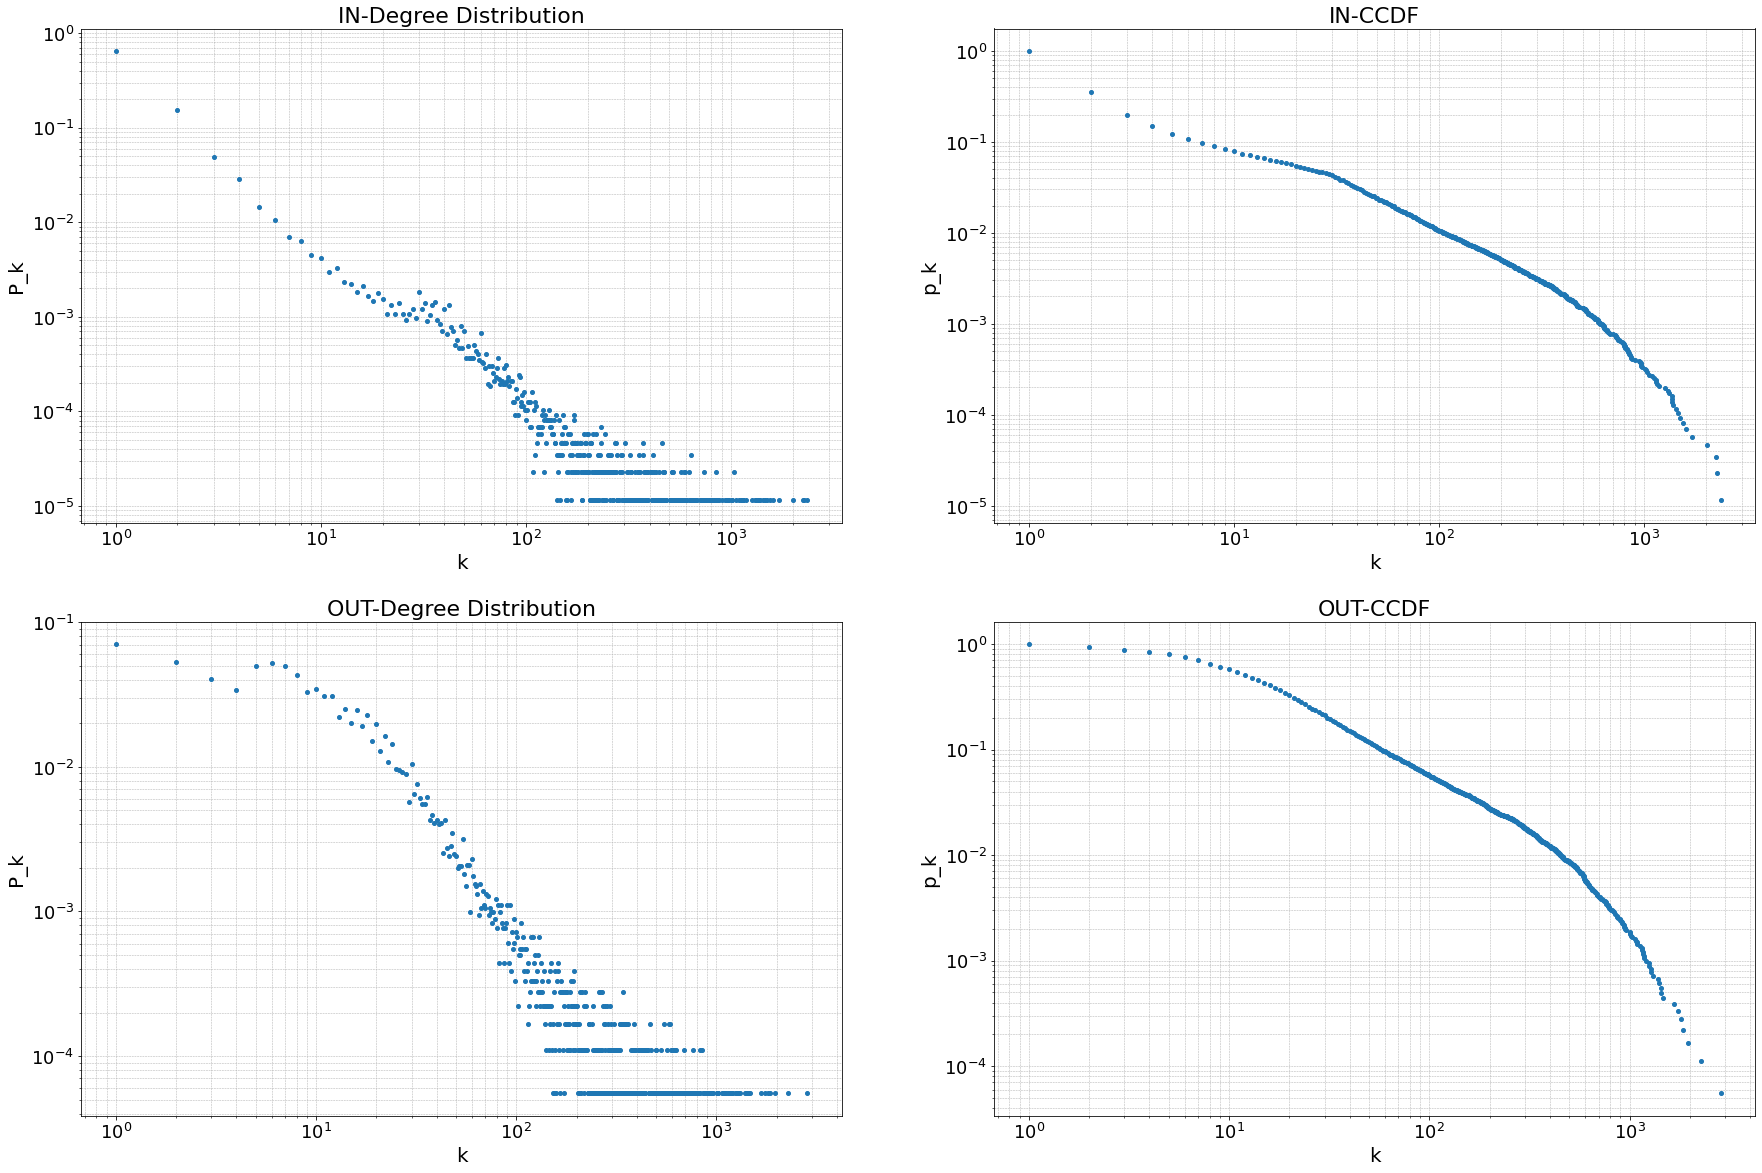

Top 10 for in degree


,Nodes,in degree
64104,UNIVERSITAT DE VALENCIA,2352
14024,ALMA MATER STUDIORUM - UNIVERSITA DI BOLOGNA,2264
55274,UNIVERSIDADE DE LISBOA,2248
34836,UNIVERSIDAD DE GRANADA,2011
94652,UNIVERSIDAD COMPLUTENSE DE MADRID,1707
10895,UNIVERZA V LJUBLJANI,1593
93426,UNIVERSITAT POLITECNICA DE VALENCIA,1548
59011,NORGES TEKNISK-NATURVITENSKAPELIGE UNIVERSITET...,1495
46338,KATHOLIEKE UNIVERSITEIT LEUVEN,1465
17775,UNIVERSIDAD DE SEVILLA,1427


Top 10 for out degree


,Nodes,out degree
14024,ALMA MATER STUDIORUM - UNIVERSITA DI BOLOGNA,2845
34836,UNIVERSIDAD DE GRANADA,2282
45687,UNIVERSITA DEGLI STUDI DI PADOVA,1966
13328,UNIVERSITA DEGLI STUDI DI ROMA LA SAPIENZA,1842
94652,UNIVERSIDAD COMPLUTENSE DE MADRID,1815
64104,UNIVERSITAT DE VALENCIA,1753
21007,UNIVERSITA DEGLI STUDI DI TORINO,1673
10895,UNIVERZA V LJUBLJANI,1469
55274,UNIVERSIDADE DE LISBOA,1443
94671,Association Ouvrière des Compagnons du Devoir ...,1437


In [6]:
scores = ns.degree_disribution(adj_matrix_crs, nodes_df, print_graph=True)
ns.display_top_n(scores, 10, 'in degree')
ns.display_top_n(scores, 10, 'out degree')

### HITS (NetworkX)

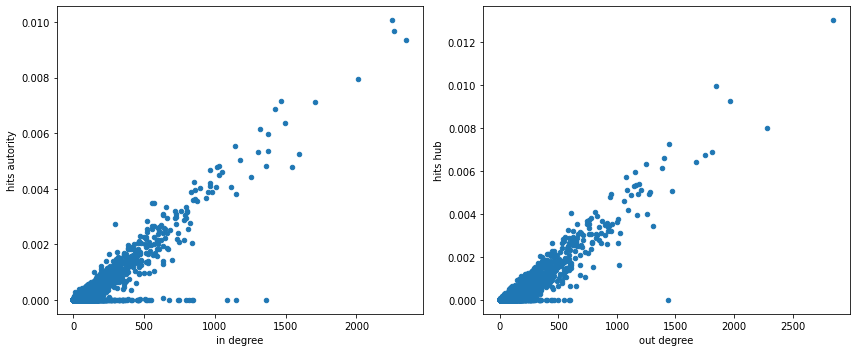

Top 10 for hits hub


,Nodes,hits hub
14024,ALMA MATER STUDIORUM - UNIVERSITA DI BOLOGNA,0.012997
13328,UNIVERSITA DEGLI STUDI DI ROMA LA SAPIENZA,0.009939
45687,UNIVERSITA DEGLI STUDI DI PADOVA,0.009242
34836,UNIVERSIDAD DE GRANADA,0.007984
55274,UNIVERSIDADE DE LISBOA,0.007260
94652,UNIVERSIDAD COMPLUTENSE DE MADRID,0.006882
64104,UNIVERSITAT DE VALENCIA,0.006745
46338,KATHOLIEKE UNIVERSITEIT LEUVEN,0.006614
21007,UNIVERSITA DEGLI STUDI DI TORINO,0.006424
56291,TECHNISCHE UNIVERSITAET MUENCHEN,0.006332


Top 10 for hits autority


,Nodes,hits autority
55274,UNIVERSIDADE DE LISBOA,0.010064
14024,ALMA MATER STUDIORUM - UNIVERSITA DI BOLOGNA,0.009687
64104,UNIVERSITAT DE VALENCIA,0.009342
34836,UNIVERSIDAD DE GRANADA,0.007957
46338,KATHOLIEKE UNIVERSITEIT LEUVEN,0.007145
94652,UNIVERSIDAD COMPLUTENSE DE MADRID,0.007113
17775,UNIVERSIDAD DE SEVILLA,0.006877
59011,NORGES TEKNISK-NATURVITENSKAPELIGE UNIVERSITET...,0.006364
86316,UNIVERSITAT DE BARCELONA,0.006159
96951,UNIVERZITA KARLOVA,0.005982


In [7]:
df = ns.hits_alg(adj_matrix_crs, nodes_df, score_df=scores, print_graph=True)
scores = pd.merge(scores, df, on='Nodes')

ns.display_top_n(scores, 10, 'hits hub')
ns.display_top_n(scores, 10, 'hits autority')

### PageRank (NetworkX)

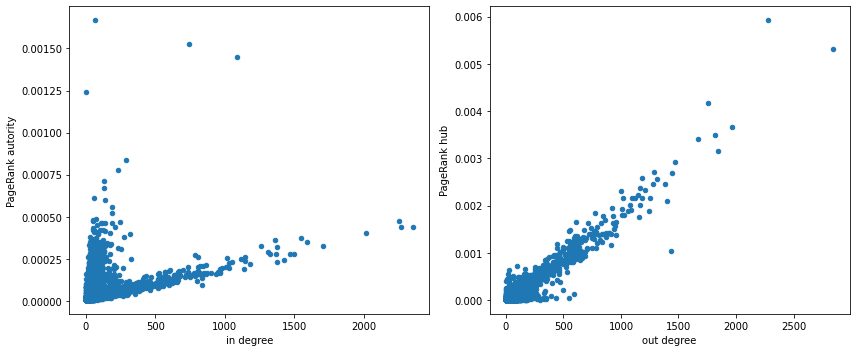

Top 10 for PageRank hub


,Nodes,PageRank hub
34836,UNIVERSIDAD DE GRANADA,0.005921
14024,ALMA MATER STUDIORUM - UNIVERSITA DI BOLOGNA,0.005318
64104,UNIVERSITAT DE VALENCIA,0.004164
45687,UNIVERSITA DEGLI STUDI DI PADOVA,0.003659
94652,UNIVERSIDAD COMPLUTENSE DE MADRID,0.003494
21007,UNIVERSITA DEGLI STUDI DI TORINO,0.003403
13328,UNIVERSITA DEGLI STUDI DI ROMA LA SAPIENZA,0.003159
10895,UNIVERZA V LJUBLJANI,0.002931
32293,UNIVERSIDAD POLITECNICA DE MADRID,0.002716
55274,UNIVERSIDADE DE LISBOA,0.002686


Top 10 for PageRank autority


,Nodes,PageRank autority
71241,"SDRUJENIE "" FC PALDIN"" PLOVDIV",0.001667
73400,FUNDACJA KRZYZOWA DLA POROZUMIENIA EUROPEJSKIEGO,0.001525
88006,ADC Technology Training Ltd,0.001450
45897,Hogbergsskolan,0.001240
54811,STICHTING DE OLDE VECHTE,0.000840
63986,Europahaus Marienberg,0.000777
3059,DHKEXE DHMOTIKH EPIXEIRHSH DHMOY XYLOKASTROY-E...,0.000713
26550,ASSOCIAZIONE ARTEMIDE,0.000671
1088,Rezeknes pilsetas Nacionalo biedribu kulturas ...,0.000609
76202,Bildungsnetzwerk Magdeburg gGmbH,0.000598


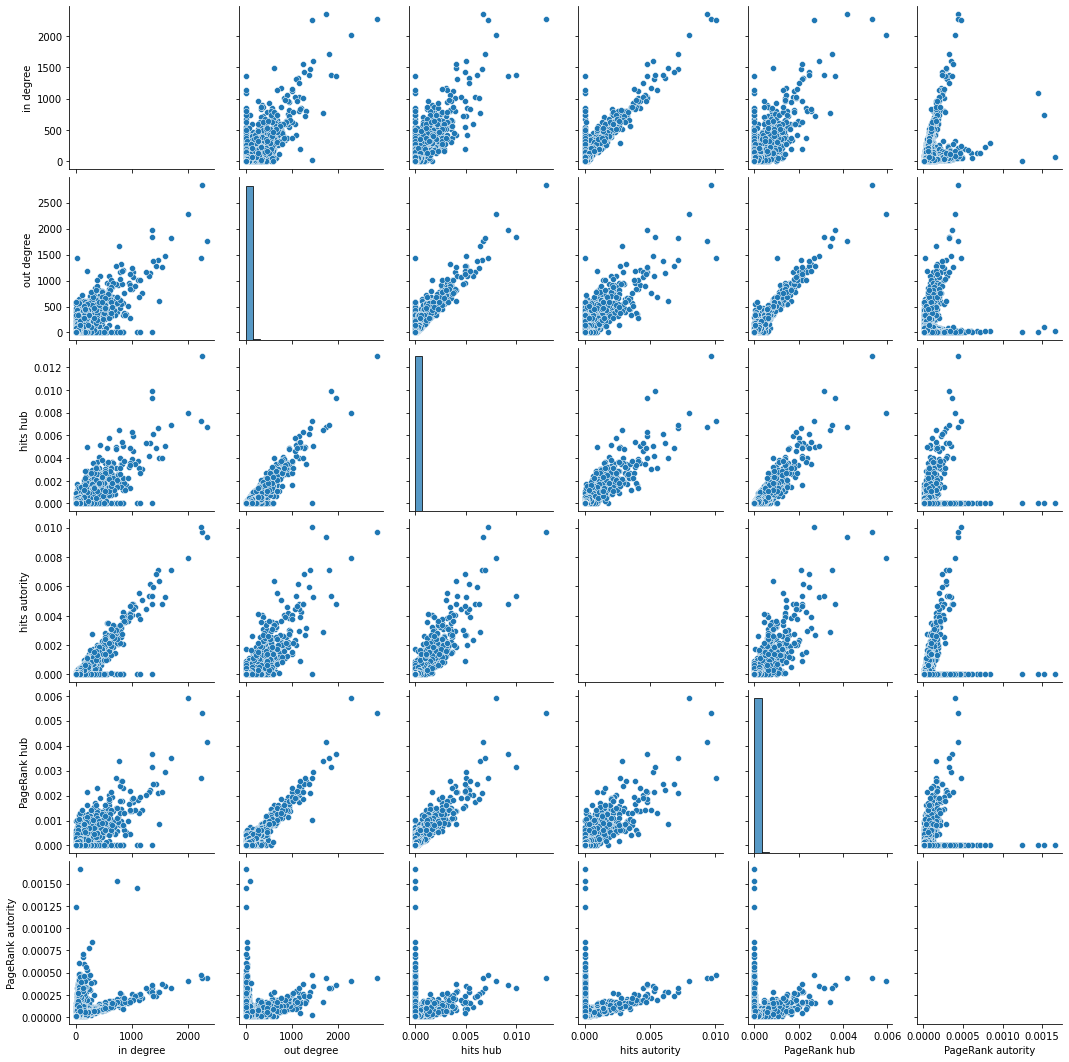

In [8]:
df = ns.pagerank_alg(adj_matrix_crs, nodes_df, score_df=scores, print_graph=True)
scores = pd.merge(scores, df, on='Nodes')

ns.display_top_n(scores, 10, 'PageRank hub')
ns.display_top_n(scores, 10, 'PageRank autority')
# ci vuole troppo a farlo
# sns.pairplot(scores)
# plt.show()
from IPython.display import Image
Image('pairplot_score.png',)

### Assortativity

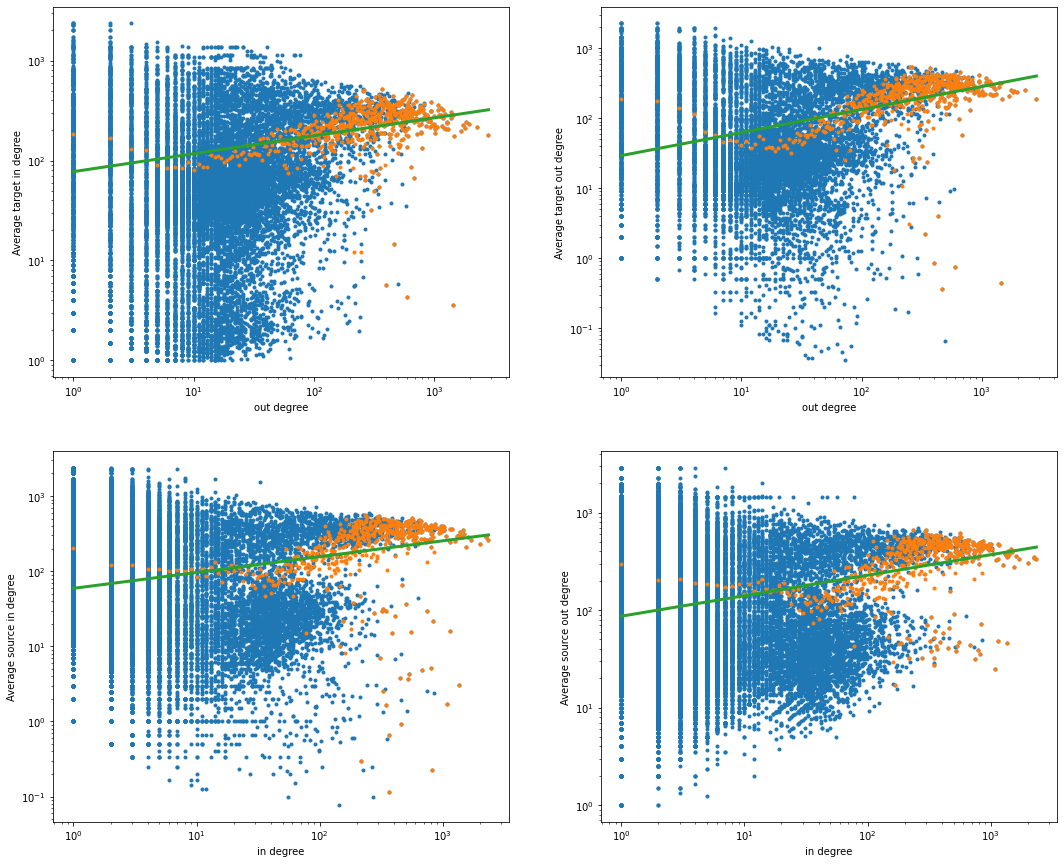

(0.17916506276142286,
 0.3295387858297887,
 0.2108173863056326,
 0.2099590349741398)

In [9]:
edges = mobility_df[['Sending Organization','Receiving Organization']].copy()
edges.rename({'Sending Organization': 'source', 'Receiving Organization':'target'},axis=1, inplace=True)
ns.assortativity_calc(edges, adj_matrix_crs, nodes_df, True)